# Convolutional neural networks

Olexander Chepurnoi, Yaroslava Lochman

In [145]:
_colab = True
if _colab:
  print('Using Google Colab')
  
  # !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive 
  from google.colab import auth 
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  
  # !pip install tensorboardcolab
  from tensorboardcolab import *
  
import pickle
import numpy as np
import keras
import matplotlib.pyplot as plt
print('Keras version using:', keras.__version__)

Using Google Colab
Keras version using: 2.2.4


In [0]:
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import TensorBoard
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.regularizers import l2 as L2


## Loading images

In [0]:
if _colab:
  from keras.datasets import cifar10
  (train_images, train_labels), (cv_images, cv_labels) = cifar10.load_data()
else:
  train_images, train_labels = pickle.load(open('data/train_set_all.pkl', 'rb'))
  cv_images, cv_labels = pickle.load(open('data/test_set_all.pkl', 'rb'))

In [26]:
print(train_images.shape)
print(len(train_labels))

(50000, 32, 32, 3)
50000


In [27]:
print(cv_images.shape)
print(len(cv_labels))

(10000, 32, 32, 3)
10000


In [28]:
print(train_labels[0:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [0]:
def show_image(np_array):
    %matplotlib inline
    plt.figure()
    plt.imshow(np_array)
    
def show_example(data_set, labels, example_index):
    show_image(data_set[example_index])
    print('Label: ', labels[example_index])

Label:  [6]


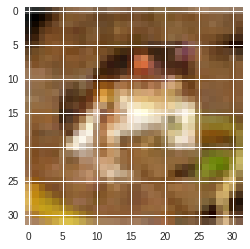

In [31]:
show_example(train_images, train_labels, example_index = 0)

Label:  [3]


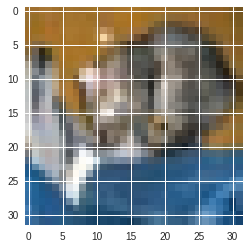

In [32]:
show_example(cv_images, cv_labels, example_index = 0)

## Preprocessing

In [0]:
num_classes = 10
train_y = np_utils.to_categorical(train_labels, num_classes)
cv_y = np_utils.to_categorical(cv_labels, num_classes)

train_images = train_images.astype('float32')
cv_images = cv_images.astype('float32')
train_images /= 255
cv_images /= 255

## Building AlexNet

In [0]:
def create_AlexNet(num_classes=10, k=1, weight_decay=0.0005):
  model = Sequential()
  # 1
  model.add(Conv2D(48 * k, (11, 11), strides=(4,4), padding='same', name="1_conv",
                   input_shape=train_images.shape[1:],
                   kernel_regularizer=L2(weight_decay)))

  model.add(BatchNormalization(name="1_bn"))
  model.add(Activation('relu', name="1_relu"))
  model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same', name="1_maxpool"))
  
  # 2
  model.add(Conv2D(128 * k, (5, 5), strides=(1,1), padding='same', name="2_conv",
                   kernel_regularizer=L2(weight_decay)))
  model.add(BatchNormalization(name="2_bn"))
  model.add(Activation('relu', name="2_relu"))
  model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same', name="2_maxpool"))
#   if dropout:
#     model.add(Dropout(0.5))

  # 3
  model.add(Conv2D(192 * k, (3, 3),  strides=(1,1), padding='same', name="3_conv",
                   kernel_regularizer=L2(weight_decay)))
  model.add(Activation('relu', name="3_relu"))
    
  # 4
  model.add(Conv2D(192 * k, (3, 3),  strides=(1,1), padding='same', name="4_conv",
                   kernel_regularizer=L2(weight_decay)))
  model.add(Activation('relu', name="4_relu"))
    
  # 5
  model.add(Conv2D(128 * k, (3, 3),  strides=(1,1), padding='same', name="5_conv",
                   kernel_regularizer=L2(weight_decay)))
  model.add(BatchNormalization(name="5_bn"))
  model.add(Activation('relu', name="5_relu"))
  model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same', name="5_maxpool"))
#   if dropout:
#     model.add(Dropout(0.5))
  
  # 6
  model.add(Flatten(name="6_flatten"))
  model.add(Dropout(0.5, name="6_dropout"))
  model.add(Dense(2048 * k, name="6_fc"))
  model.add(BatchNormalization(name="6_bn"))
  model.add(Activation('relu', name="6_relu"))
    
  # 7
  model.add(Dropout(0.5, name="7_dropout"))
  model.add(Dense(2048 * k, name="7_fc"))
  model.add(BatchNormalization(name="7_bn"))
  model.add(Activation('relu', name="7_relu"))

  # 8
  model.add(Dense(num_classes, name="8_fc"))
  model.add(BatchNormalization(name="8_bn"))
  model.add(Activation('softmax', name="8_softmax"))
  return model

## Training AlexNet

In [138]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://ab1b3544.ngrok.io


In [146]:
model = create_AlexNet(num_classes)
model.summary()

sgd = keras.optimizers.SGD(lr=0.01, decay=5*1e-4, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                              patience=10, cooldown=1,
                                              min_lr=0.00001, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 8, 8, 48)          17472     
_________________________________________________________________
1_bn (BatchNormalization)    (None, 8, 8, 48)          192       
_________________________________________________________________
1_relu (Activation)          (None, 8, 8, 48)          0         
_________________________________________________________________
1_maxpool (MaxPooling2D)     (None, 4, 4, 48)          0         
_________________________________________________________________
2_conv (Conv2D)              (None, 4, 4, 128)         153728    
_________________________________________________________________
2_bn (BatchNormalization)    (None, 4, 4, 128)         512       
_________________________________________________________________
2_relu (Activation)          (None, 4, 4, 128)         0         
__________

In [140]:
epoch_start = 0
batch_size = 128
epochs = 90

model.fit(train_images, train_y,
      initial_epoch=epoch_start,
      batch_size=batch_size,
      epochs=epochs,
      shuffle=True,
      validation_data=(cv_images, cv_y),
      callbacks=[reduce_lr, TensorBoardColabCallback(tbc)])

Train on 50000 samples, validate on 10000 samples
Epoch 1/90
50000/50000 [==============================] - 17s 330us/step - loss: 1.8845 - acc: 0.2605 - val_loss: 2.6133 - val_acc: 0.2209
Epoch 2/90
50000/50000 [==============================] - 13s 267us/step - loss: 1.5592 - acc: 0.4110 - val_loss: 1.9342 - val_acc: 0.3510
Epoch 3/90
50000/50000 [==============================] - 13s 266us/step - loss: 1.3378 - acc: 0.5117 - val_loss: 2.1123 - val_acc: 0.3516
Epoch 4/90
50000/50000 [==============================] - 13s 266us/step - loss: 1.2160 - acc: 0.5639 - val_loss: 1.6544 - val_acc: 0.4330
Epoch 5/90
50000/50000 [==============================] - 13s 265us/step - loss: 1.1181 - acc: 0.6056 - val_loss: 1.9566 - val_acc: 0.4015
Epoch 6/90
50000/50000 [==============================] - 13s 264us/step - loss: 1.0463 - acc: 0.6357 - val_loss: 1.4255 - val_acc: 0.5409
Epoch 7/90
50000/50000 [==============================] - 13s 266us/step - loss: 0.9789 - acc: 0.6610 - val_loss: 1.

In [150]:
scores = model.evaluate(cv_images, cv_y, verbose=1)
print('Test loss: {:.2f}'.format(scores[0]))
print('Test accuracy: {:.2f}%'.format(scores[1]*100))

10000/10000 [==============================] - 2s 242us/step
Test loss: 1.83
Test accuracy: 67.32%


In [142]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'alex-net_vanilla.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

if _colab:
  model_file = drive.CreateFile({'title' : model_name})
  model_file.SetContentFile(model_path)
  model_file.Upload()

Saved trained model at /content/saved_models/alex-net_vanilla.h5 


## Improving AlexNet

AlexNet was specifically created for a large-scale ImageNet dataset, that is much more complex than CIFAR-10, e.g. it has images of higher quality (224x224 in ImageNet vs. 32x32 in CIFAR), a huge (1000) number of various classes with its hierarchy (vs. simple 10 in CIFAR), 1.2 million images in total vs. 60 thousand in CIFAR. The architecture is as complex as it should be for such dataset, but for ours, it over-complicated and thus is easy to overfit, as we can see from the classification results above. So to achieve a good generalization, we need to revisit the model and optimization configurations. For the architecture we suggest to remove 2 layers (one convolutional and one dense) as it is clear that the network is too deep for such data, and reduce kernel size of convolution to 3x3 for every layer and reduce the number of filters. We also use dropout and batch normalization techniques, and decrease weight decay multiplier a little bit. Also, we train the model with RMSProp, and as was originally proposed, reduce learning rate by 10 when the validation error doesn't improve.

In [0]:
def create_modified_AlexNet(weight_decay=1e-4):
  model = Sequential()
  # 1
  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=train_images.shape[1:],
                   kernel_regularizer=L2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  # 2
  model.add(Conv2D(32, (3, 3), padding='same',
                   kernel_regularizer=L2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # 3
  model.add(Conv2D(64, (3, 3), padding='same',
                   kernel_regularizer=L2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # 4
  model.add(Conv2D(128, (3, 3), padding='same',
                   kernel_regularizer=L2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  
#   5
#   model.add(Conv2D(64, (3, 3), padding='same'),
#                    kernel_regularizer=L2(weight_decay))
#   model.add(Activation('relu'))
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.5))
  
  # 6
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  
#   # 7
#   model.add(Dense(512))
#   model.add(Activation('relu'))
#   model.add(Dropout(0.5))
  
  # 8
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  return model

In [208]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://00d1e01d.ngrok.io


In [0]:
model = create_modified_AlexNet()
# model.summary()


rmsprop = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                              patience=10, cooldown=1,
                                              min_lr=0.00001, verbose=1)

In [213]:
epoch_start = 0
batch_size = 64
epochs = 90

model.fit(train_images, train_y,
      initial_epoch=epoch_start,
      batch_size=batch_size,
      epochs=epochs,
      shuffle=True,
      validation_data=(cv_images, cv_y),
      callbacks=[reduce_lr, TensorBoardColabCallback(tbc)])

Train on 50000 samples, validate on 10000 samples
Epoch 1/90
50000/50000 [==============================] - 36s 727us/step - loss: 1.6321 - acc: 0.4363 - val_loss: 1.5331 - val_acc: 0.4693
Epoch 2/90
50000/50000 [==============================] - 34s 672us/step - loss: 1.2711 - acc: 0.5634 - val_loss: 1.4347 - val_acc: 0.5035
Epoch 3/90
50000/50000 [==============================] - 34s 670us/step - loss: 1.1662 - acc: 0.6098 - val_loss: 1.2136 - val_acc: 0.6038
Epoch 4/90
50000/50000 [==============================] - 34s 672us/step - loss: 1.0959 - acc: 0.6356 - val_loss: 1.2516 - val_acc: 0.6057
Epoch 5/90
50000/50000 [==============================] - 34s 671us/step - loss: 1.0363 - acc: 0.6594 - val_loss: 1.0003 - val_acc: 0.6642
Epoch 6/90
50000/50000 [==============================] - 33s 669us/step - loss: 1.0033 - acc: 0.6733 - val_loss: 1.0992 - val_acc: 0.6340
Epoch 7/90
50000/50000 [==============================] - 33s 669us/step - loss: 0.9673 - acc: 0.6891 - val_loss: 1.

In [214]:
scores = model.evaluate(cv_images, cv_y, verbose=1)
print('Test loss: {:.2f}'.format(scores[0]))
print('Test accuracy: {:.2f}%'.format(scores[1]*100))

10000/10000 [==============================] - 2s 245us/step
Test loss: 0.60
Test accuracy: 83.09%


In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'alex-net_modified.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

if _colab:
  model_file = drive.CreateFile({'title' : model_name})
  model_file.SetContentFile(model_path)
  model_file.Upload()

### Data augmentation

First we trained with the raw data only. But eventually we suggest using data augmentation to enlarge and diversify training data. 

In [197]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False, 
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0)

datagen.fit(train_images)

epoch_start = 0
batch_size = 64
epochs = 100

model.fit_generator(datagen.flow(train_images, train_y,
                                 batch_size=batch_size),
                    initial_epoch=epoch_start,
                    epochs=epochs,
                    validation_data=(cv_images, cv_y),
                    workers=4, 
                    steps_per_epoch=1500,  
                    callbacks=[reduce_lr, TensorBoardColabCallback(tbc)])

Epoch 1/100
1500/1500 [==============================] - 87s 58ms/step - loss: 1.6817 - acc: 0.4236 - val_loss: 1.4184 - val_acc: 0.5841
Epoch 2/100
1500/1500 [==============================] - 82s 55ms/step - loss: 1.3462 - acc: 0.5489 - val_loss: 1.6191 - val_acc: 0.5419
Epoch 3/100
1500/1500 [==============================] - 82s 55ms/step - loss: 1.2524 - acc: 0.5886 - val_loss: 1.2213 - val_acc: 0.6376
Epoch 4/100
1500/1500 [==============================] - 82s 55ms/step - loss: 1.1878 - acc: 0.6151 - val_loss: 1.2403 - val_acc: 0.6347
Epoch 5/100
1500/1500 [==============================] - 82s 54ms/step - loss: 1.1124 - acc: 0.6403 - val_loss: 1.1737 - val_acc: 0.6463
Epoch 6/100
1500/1500 [==============================] - 82s 54ms/step - loss: 1.0494 - acc: 0.6630 - val_loss: 1.1544 - val_acc: 0.6602
Epoch 7/100
1500/1500 [==============================] - 82s 54ms/step - loss: 0.9891 - acc: 0.6826 - val_loss: 1.0396 - val_acc: 0.6720
Epoch 8/100
1500/1500 [==================

In [199]:
scores = model.evaluate(cv_images, cv_y, verbose=1)
print('Test loss: {:.2f}'.format(scores[0]))
print('Test accuracy: {:.2f}%'.format(scores[1]*100))

10000/10000 [==============================] - 2s 223us/step
Test loss: 0.54
Test accuracy: 84.12%


In [206]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'alex-net_modified_aug.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

if _colab:
  model_file = drive.CreateFile({'title' : model_name})
  model_file.SetContentFile(model_path)
  model_file.Upload()

Saved trained model at /content/saved_models/alex-net_modified.h5 


We got CV accuracy 84.12%.